In [15]:
# === Cell 0: Imports, paths, config ===
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.feature import hog

# ---- Paths (same base as before) ----
BASE = Path(r"c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project")

DATA = BASE / "data"
PROC_DIR = DATA / "processed_images"
LABELS_CSV = DATA / "labels.csv"               # for optional evaluation
RESULTS_DIR = BASE / "results"
HILITE_DIR = RESULTS_DIR / "highlighted_images"
HILITE_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV = RESULTS_DIR / "predictions.csv"

MODELS_DIR = BASE / "models"
MODEL_PATH = MODELS_DIR / "final_model.pkl"

METRICS_DIR = BASE / "results" / "models"
SWEEP_PATH  = METRICS_DIR / "threshold_sweep_val.csv"  # optional

# ---- Grid / feature config (must match training) ----
IMG_W, IMG_H = 800, 600
CELL_W, CELL_H = IMG_W // 8, IMG_H // 8  # 100x75

HOG_PARAMS = dict(
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    feature_vector=True
)

HIST_BINS = 16

# ---- Inference threshold ----
USE_BEST_THR = True      # set False to force THRESH=0.5
THRESH = 0.8
if USE_BEST_THR and SWEEP_PATH.exists():
    df_thr = pd.read_csv(SWEEP_PATH)
    # pick threshold with max F1 (ties broken by higher PR-AUC, then ROC-AUC)
    df_thr = df_thr.sort_values(["f1", "pr_auc", "roc_auc"], ascending=False)
    THRESH = float(df_thr.iloc[0]["thr"])

THRESH = 0.75
print("Using threshold:", THRESH)

print("Model path exists:", MODEL_PATH.exists())
print("Processed images dir exists:", PROC_DIR.exists())
print("Predictions will be saved to:", PRED_CSV)


Using threshold: 0.75
Model path exists: True
Processed images dir exists: True
Predictions will be saved to: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\results\predictions.csv


In [2]:
# === Cell 1: Load model ===
with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)
print(type(model))


<class 'sklearn.pipeline.Pipeline'>


In [3]:
# === Cell 2: Feature extraction (same as training) ===

def _to_bgr(img):
    if img is None:
        return None
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    return img

def color_hist_feats(bgr, bins=HIST_BINS):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    feats = []
    for space in (rgb, hsv):
        for ch in range(3):
            h, _ = np.histogram(space[:, :, ch], bins=bins, range=(0, 255), density=True)
            feats.append(h.astype(np.float32))
    return np.concatenate(feats)

def hog_feats(bgr, hog_params=HOG_PARAMS):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    h = hog(gray, **hog_params)
    return h.astype(np.float32)

def extract_features(cell_bgr):
    bgr = _to_bgr(cell_bgr)
    ch = color_hist_feats(bgr, bins=HIST_BINS)  # 96 dims
    hg = hog_feats(bgr, hog_params=HOG_PARAMS)
    return np.concatenate([ch, hg]).astype(np.float32)


In [4]:
# === Cell 3: Slicing & drawing helpers ===
def slice_cells(img):
    h, w = img.shape[:2]
    if (w, h) != (IMG_W, IMG_H):
        raise ValueError(f"Processed image must be {IMG_W}x{IMG_H}, got {w}x{h}")
    cells, coords = [], []
    for r in range(8):
        for c in range(8):
            y0, y1 = r * CELL_H, (r + 1) * CELL_H
            x0, x1 = c * CELL_W, (c + 1) * CELL_W
            cells.append(img[y0:y1, x0:x1])
            coords.append((x0, y0, x1, y1))
    return cells, coords

def draw_grid(img, preds, thickness=2):
    """Green rectangles on predicted-positive cells."""
    out = img.copy()
    k = 0
    for r in range(8):
        for c in range(8):
            y0, y1 = r * CELL_H, (r + 1) * CELL_H
            x0, x1 = c * CELL_W, (c + 1) * CELL_W
            if preds[k] == 1:
                cv2.rectangle(out, (x0, y0), (x1, y1), (0, 255, 0), thickness)
            k += 1
    return out


In [5]:
# === Cell 4: Inference over all processed images ===
rows = []
img_files = sorted([p for p in PROC_DIR.iterdir() if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}])

for img_path in tqdm(img_files):
    img = cv2.imread(str(img_path))
    if img is None or img.shape[:2] != (IMG_H, IMG_W):
        print(f"[SKIP] {img_path.name} unreadable or wrong size")
        continue

    cells, coords = slice_cells(img)
    X = np.vstack([extract_features(c) for c in cells])

    # Get probabilities if available
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)[:, 1]
    else:
        # decision_function fallback -> min-max to [0,1]
        dec = model.decision_function(X)
        proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)

    preds = (proba >= THRESH).astype(int)

    # Save highlighted overlay
    overlay = draw_grid(img, preds)
    cv2.imwrite(str(HILITE_DIR / img_path.name), overlay)

    # Build CSV row
    row = {"ImageFileName": img_path.name}
    for i, v in enumerate(preds, start=1):
        row[f"c{i:02d}"] = int(v)
    rows.append(row)

# Write CSV in required column order
col_order = ["ImageFileName"] + [f"c{i:02d}" for i in range(1, 65)]
pred_df = pd.DataFrame(rows, columns=col_order)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(PRED_CSV, index=False)

print(f"Wrote {len(pred_df)} rows to {PRED_CSV}")
print(f"Highlighted images saved to: {HILITE_DIR}")
pred_df.head()


  0%|          | 0/465 [00:00<?, ?it/s]

 20%|██        | 94/465 [00:30<01:57,  3.15it/s]

[SKIP] CIMG0117.JPG unreadable or wrong size


 22%|██▏       | 101/465 [00:32<01:48,  3.35it/s]

[SKIP] CIMG0120(1).JPG unreadable or wrong size


 30%|██▉       | 139/465 [00:43<01:40,  3.24it/s]

[SKIP] CIMG0144~3.JPG unreadable or wrong size


 40%|███▉      | 185/465 [00:57<01:26,  3.25it/s]

[SKIP] CIMG0209.JPG unreadable or wrong size


 40%|████      | 188/465 [00:58<01:17,  3.58it/s]

[SKIP] CIMG0210.JPG unreadable or wrong size


 41%|████      | 190/465 [00:58<01:04,  4.24it/s]

[SKIP] CIMG0218.JPG unreadable or wrong size


 42%|████▏     | 195/465 [00:59<01:10,  3.83it/s]

[SKIP] CIMG0228(1).JPG unreadable or wrong size


 43%|████▎     | 199/465 [01:01<01:12,  3.66it/s]

[SKIP] CIMG0230~2.JPG unreadable or wrong size


 43%|████▎     | 201/465 [01:01<01:03,  4.15it/s]

[SKIP] CIMG0232~2.JPG unreadable or wrong size
[SKIP] CIMG0233.JPG unreadable or wrong size


 69%|██████▉   | 323/465 [01:39<00:43,  3.29it/s]

[SKIP] IMG-20140317-WA0001.jpg unreadable or wrong size


 76%|███████▌  | 354/465 [01:49<00:35,  3.16it/s]

[SKIP] IMG_3332.JPG unreadable or wrong size


 77%|███████▋  | 356/465 [01:49<00:26,  4.04it/s]

[SKIP] IMG_3334.JPG unreadable or wrong size
[SKIP] IMG_3337.JPG unreadable or wrong size


 78%|███████▊  | 364/465 [01:51<00:28,  3.51it/s]

[SKIP] IMG_3369.JPG unreadable or wrong size


 81%|████████▏ | 378/465 [01:55<00:26,  3.29it/s]

[SKIP] IMG_3403.JPG unreadable or wrong size


 82%|████████▏ | 380/465 [01:56<00:21,  3.97it/s]

[SKIP] IMG_3406.JPG unreadable or wrong size
[SKIP] IMG_3409.JPG unreadable or wrong size


 84%|████████▎ | 389/465 [01:58<00:21,  3.48it/s]

[SKIP] IMG_3419.JPG unreadable or wrong size


 84%|████████▍ | 391/465 [01:58<00:17,  4.21it/s]

[SKIP] IMG_3439.JPG unreadable or wrong size
[SKIP] IMG_3477.JPG unreadable or wrong size


 85%|████████▌ | 396/465 [01:59<00:15,  4.43it/s]

[SKIP] IMG_3653.JPG unreadable or wrong size
[SKIP] IMG_3674.JPG unreadable or wrong size
[SKIP] IMG_3676.JPG unreadable or wrong size


 86%|████████▌ | 400/465 [02:00<00:10,  6.30it/s]

[SKIP] IMG_3686.JPG unreadable or wrong size


 86%|████████▋ | 402/465 [02:00<00:09,  6.32it/s]

[SKIP] IMG_3699.JPG unreadable or wrong size
[SKIP] IMG_3700.JPG unreadable or wrong size
[SKIP] IMG_3701.JPG unreadable or wrong size


 87%|████████▋ | 406/465 [02:00<00:07,  7.66it/s]

[SKIP] IMG_3747.JPG unreadable or wrong size


 88%|████████▊ | 408/465 [02:01<00:08,  7.02it/s]

[SKIP] IMG_3761.JPG unreadable or wrong size
[SKIP] IMG_3839.JPG unreadable or wrong size


 88%|████████▊ | 411/465 [02:01<00:07,  7.48it/s]

[SKIP] IMG_3858.JPG unreadable or wrong size


 93%|█████████▎| 434/465 [02:08<00:09,  3.33it/s]

[SKIP] IMG_4194.JPG unreadable or wrong size


 99%|█████████▉| 461/465 [02:16<00:01,  3.21it/s]

[SKIP] Rimg0149s.jpg unreadable or wrong size


100%|██████████| 465/465 [02:17<00:00,  3.39it/s]

Wrote 431 rows to c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\results\predictions.csv
Highlighted images saved to: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\results\highlighted_images


,ImageFileName,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,c64
0,100820081692.jpg,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,100820081693.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,100820081694.jpg,0,1,0,0,1,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,100820081695.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,141120142185.jpg,1,0,0,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0


In [6]:
# === Cell 5 (optional): Evaluate predictions against labels.csv ===
if LABELS_CSV.exists():
    labels_df = pd.read_csv(LABELS_CSV)
    if "ImageFileName" not in labels_df.columns:
        cands = [c for c in labels_df.columns if c.lower() in
                 ["imagefilename","image_file_name","filename","image","image_name","file","file_name"]]
        if cands:
            labels_df = labels_df.rename(columns={cands[0]: "ImageFileName"})
    if "ImageFileName" in labels_df.columns:
        merged = pred_df.merge(labels_df, on="ImageFileName", suffixes=("_pred", "_true"))
        y_true = merged[[f"c{i:02d}_true" for i in range(1,65)]].to_numpy().ravel().astype(int)
        y_pred = merged[[f"c{i:02d}_pred" for i in range(1,65)]].to_numpy().ravel().astype(int)

        from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
        acc = accuracy_score(y_true, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)

        print(f"Cells | Acc {acc:.4f} | P {p:.4f} | R {r:.4f} | F1 {f1:.4f}")

        # Per-image positive counts (sanity)
        true_pos_per_img = merged[[f"c{i:02d}_true" for i in range(1,65)]].sum(axis=1)
        pred_pos_per_img = merged[[f"c{i:02d}_pred" for i in range(1,65)]].sum(axis=1)
        corr = np.corrcoef(true_pos_per_img, pred_pos_per_img)[0,1]
        print(f"Correlation of pos-count per image (true vs pred): {corr:.3f}")
    else:
        print("[INFO] Could not find filename column in labels.csv; skipping eval.")
else:
    print("[INFO] labels.csv not found; skipping evaluation.")


Cells | Acc 0.7774 | P 0.5570 | R 0.8227 | F1 0.6643
Correlation of pos-count per image (true vs pred): 0.686


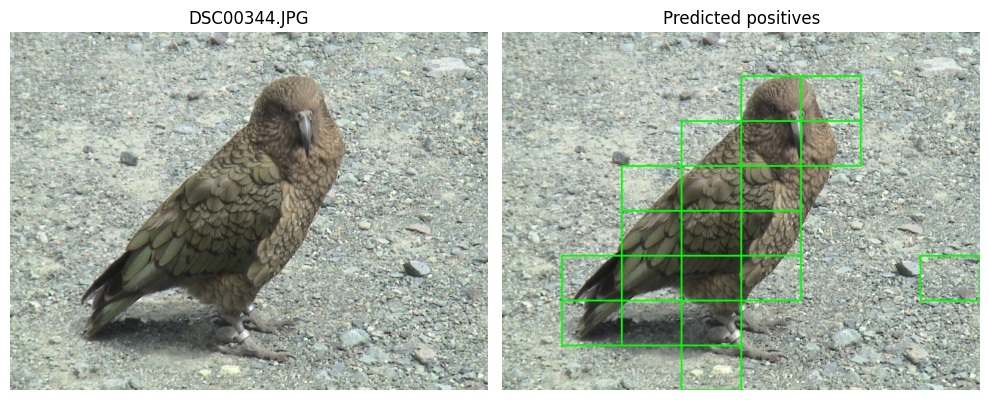

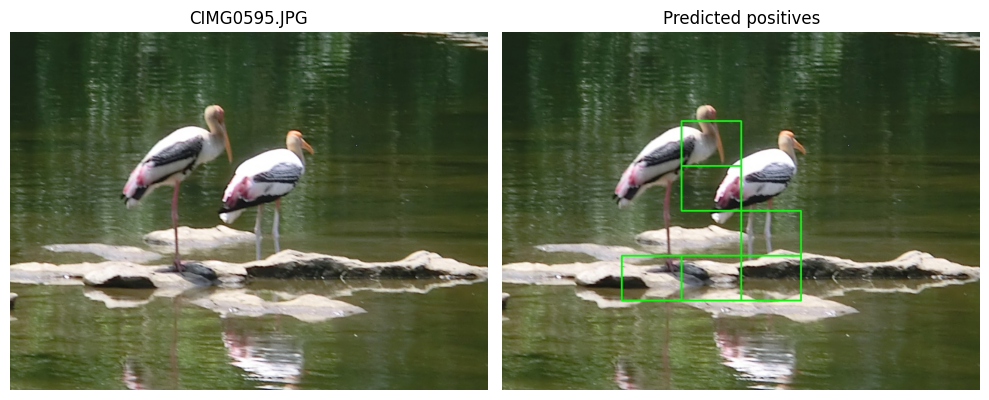

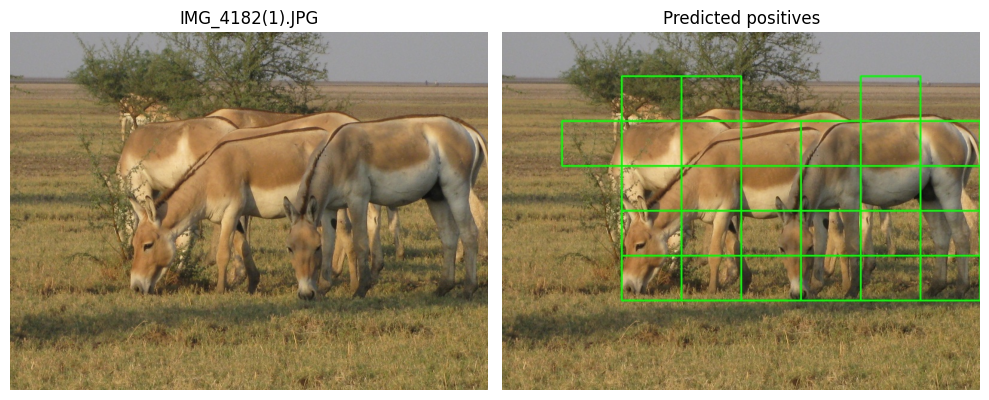

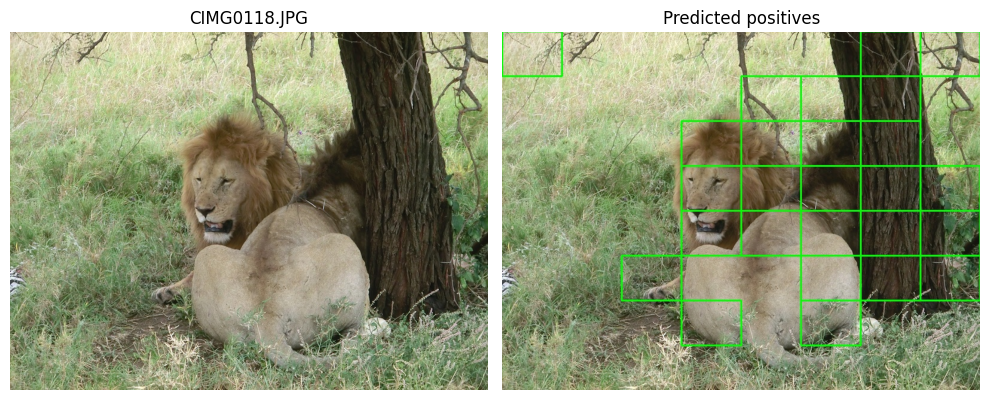

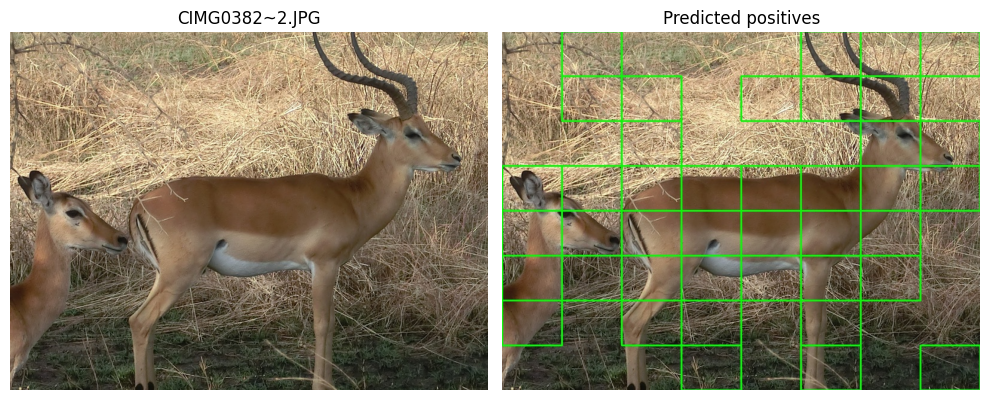

In [16]:
# === Cell 6 (optional): Visual spot-check ===
import random
samples = random.sample(list(pred_df["ImageFileName"]), k=min(5, len(pred_df)))
for name in samples:
    img = cv2.imread(str(PROC_DIR / name))
    overlay = cv2.imread(str(HILITE_DIR / name))
    if img is None or overlay is None:
        continue
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title(name); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title("Predicted positives"); plt.axis("off")
    plt.tight_layout(); plt.show()
